<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/stormCenteredProfiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install cfgrib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 72.2 MB/s eta 0:00:00


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#User parameters

In [137]:
name = "Milton"
tcNum = "14"
trackType = ""

runTime = dt(year=2024, month=10, day=7, hour=0) #1 day before Milton began its most rapid intensification

fHourStep = 6       #Normally 3 for HAFS-A
forecastLength = 48 #Normally 126 for HAFS-A.

figureSuffix = "_RI"
subfolder = "RITest/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

#Defines area to average for the sounding. Must be one of "point", "NE, "SE", "SW", "NE", or "centered"
areaAvg = "point"
areaRange = 1.0 #in degrees. Does not apply is areaAvg is "point".

#Retrieve HAFS-A Data

Get ATCF data and find interested point

Find times needed

In [138]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d_%H"
initStr, initHour = runTime.strftime(runFormat).split("_")

fcastTimes = []
for fHour in range(0, forecastLength+1, fHourStep):
  fcastTimes.append(runTime + pd.Timedelta(hours=fHour))

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [139]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

In [140]:
tcLocs = {}

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"
!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

for valid in fcastTimes:

  fHour = int((valid-runTime).total_seconds() / 3600)
  pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
  pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
  tcLocs[valid] = (pointLat, pointLon)

--2025-07-01 21:17:04--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/00/14l.2024100700.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 52.216.36.105, 52.216.138.251, 16.15.177.151, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|52.216.36.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35636 (35K) [application/octet-stream]
Saving to: ‘atcf_20241007_00.csv’

atcf_20241007_00.cs 100%[===================>]  34.80K  --.-KB/s    in 0.02s   

2025-07-01 21:17:04 (1.85 MB/s) - ‘atcf_20241007_00.csv’ saved [35636/35636]



In [141]:
tcLocs

{datetime.datetime(2024, 10, 7, 0, 0): (22.4, -93.4),
 datetime.datetime(2024, 10, 7, 6, 0): (22.2, -92.8),
 datetime.datetime(2024, 10, 7, 12, 0): (22.0, -92.0),
 datetime.datetime(2024, 10, 7, 18, 0): (22.1, -91.0),
 datetime.datetime(2024, 10, 8, 0, 0): (22.3, -90.1),
 datetime.datetime(2024, 10, 8, 6, 0): (22.5, -89.2),
 datetime.datetime(2024, 10, 8, 12, 0): (22.9, -88.4),
 datetime.datetime(2024, 10, 8, 18, 0): (23.3, -87.6),
 datetime.datetime(2024, 10, 9, 0, 0): (23.9, -86.6)}

Get data from HAFS-A output.

In [149]:
init = runTime
atm = {}
atm[init] = {}

for valid in fcastTimes:

  atm[init][valid] = {}
  initTime = init.strftime("%Y%m%d%H")

  fhour = str(int((valid-init).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initTime + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  point = tcLocs[valid]
  area = {"NE":[point[0], point[1], point[0]+areaRange, point[1]+areaRange], "SE":[point[0]-areaRange, point[1], point[0], point[1]+areaRange],
          "SW":[point[0]-areaRange, point[1]-areaRange, point[0], point[1],], "NW":[point[0], point[1]-areaRange, point[0]+areaRange, point[1]],
          "centered":[point[0]-(0.5*areaRange), point[1]-(0.5*areaRange), point[0]+(0.5*areaRange), point[1]+(0.5*areaRange)], "point":None}[areaAvg]

  for layer in atmData.isobaricInhPa.data:
    #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
    atm[init][valid][layer] = {}

    if areaAvg == "point": validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=layer, method="nearest")
    else: validPoint = atmData.sel(latitude=slice(area[0], area[2]), longitude=slice(area[1]+360, area[3]+360), isobaricInhPa=layer)

    atm[init][valid][layer]["T"] = np.mean(validPoint.t.data)
    if potentialTemp: atm[init][valid][layer]["T"] = np.mean(validPoint.t.data*((1000/layer)**0.28571)) #Formula from Stull R. 2017
    atm[init][valid][layer]["q"] = np.mean(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
    atm[init][valid][layer]["u"] = np.mean(validPoint.u.data)
    atm[init][valid][layer]["v"] = np.mean(validPoint.v.data)
    atm[init][valid][layer]["gh"] = np.mean(validPoint.gh.data)

/tmp/ipython-input-149-1501641160.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-149-1501641160.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-149-1501641160.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)
/tmp/ipython-input-149-1501641160.py:15: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set 

In [150]:
oce = {}
oce[init] = {}

for valid in fcastTimes:
  oce[init][valid] = {}
  initTime = init.strftime("%Y%m%d%H")

  oce[init][valid] = {}

  fhour = str(int((valid-init).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour
  oceFile = "mom6_" + initTime + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile

  if oceFile == 'mom6_2024100800_f000.nc': #This file is missing
    for layer in oceData.z_l.data:
      oce[init][valid][layer] = {"T":np.nan, "s":np.nan, "u":np.nan, "v":np.nan}
    continue

  oceData = xr.open_dataset(ocePath, decode_times=False)

  point = tcLocs[valid]
  area = {"NE":[point[0], point[1], point[0]+areaRange, point[1]+areaRange], "SE":[point[0]-areaRange, point[1], point[0], point[1]+areaRange],
          "SW":[point[0]-areaRange, point[1]-areaRange, point[0], point[1],], "NW":[point[0], point[1]-areaRange, point[0]+areaRange, point[1]],
          "centered":[point[0]-(0.5*areaRange), point[1]-(0.5*areaRange), point[0]+(0.5*areaRange), point[1]+(0.5*areaRange)], "point":None}[areaAvg]

  for layer in oceData.z_l.data:

    if areaAvg == "point": validPoint = oceData.sel(yh=point[0], yq=point[0], xq=point[1], xh=point[1], z_l=layer, method="nearest")
    else: validPoint = oceData.sel(yq=slice(area[0], area[2]), yh=slice(area[0], area[2]), xq=slice(area[1], area[3]), xh=slice(area[1], area[3]), z_l=layer)

    oce[init][valid][layer] = {}
    oce[init][valid][layer]["T"] = np.mean(validPoint.temp.data) + 273.15 #This is potential temperature. Converted from C to K.
    oce[init][valid][layer]["s"] = np.mean(validPoint.so.data)
    oce[init][valid][layer]["u"] = np.mean(validPoint.uo.data)
    oce[init][valid][layer]["v"] = np.mean(validPoint.vo.data)

#Figures

Single-point profiles with time

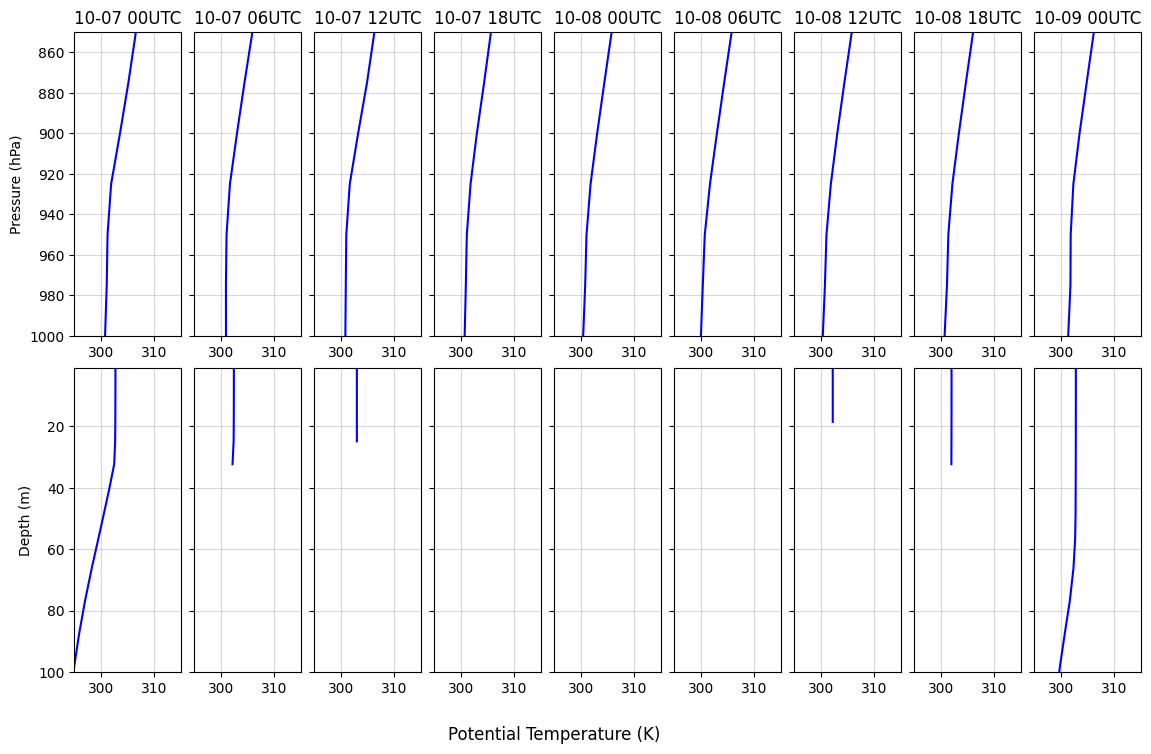

In [153]:
profFig = plt.figure(figsize=(12,8))

var = "T"
atmRange = {"T":(295,315), "u":(-20,20), "v":(-20,20)}[var]
oceRange = {"T":(295,315), "u":(-1,1), "v":(-1,1)}[var]

valids = list(atm[runTime].keys())
axCorners = np.linspace(0.1, 0.9, len(valids))
axWidth = 0.8/len(valids)

atmAxes = [profFig.add_axes([corner, 0.52, axWidth, 0.38]) for corner in axCorners]
oceAxes = [profFig.add_axes([corner, 0.1, axWidth, 0.38]) for corner in axCorners]

colors = ["blue"] * len(valids)

for time, atmAx, oceAx, color in zip(valids, atmAxes, oceAxes, colors):

  if time < runTime: continue
  ocez = list(oce[runTime][time].keys())
  oceVals = [oce[runTime][time][level][var] for level in ocez]
  oceAx.plot(oceVals, ocez, label=time.strftime("%m-%d %HUTC"), color=color)#, linestyle=linestyle)

  atmz = list(atm[runTime][time].keys())
  atmT = [atm[runTime][time][level][var] for level in atmz]
  atmAx.plot(atmT, atmz, label=time.strftime("%m-%d %HUTC"), color=color)#, linestyle=linestyle)

  atmAx.set_title(time.strftime("%m-%d %HUTC"), fontsize=12)
  oceAx.invert_yaxis()
  atmAx.invert_yaxis()
  oceAx.set_xlim(oceRange[0], oceRange[1])
  atmAx.set_xlim(atmRange[0], atmRange[1])
  oceAx.set_ylim(100,1)
  atmAx.set_ylim(1000,850)

  oceAx.grid(alpha=0.5)
  atmAx.grid(alpha=0.5)

profFig.supxlabel({"T":"Potential Temperature (K)", "u":"U-Component of Velocity (m/s)", "v":"V-Component of Velocity (m/s)"}[var])
oceAxes[0].set_ylabel("Depth (m)")
atmAxes[0].set_ylabel("Pressure (hPa)")
for ax in atmAxes[1:] + oceAxes[1:]: ax.set_yticklabels([])

plt.savefig(f"{var}StormCenteredProfiles.png")
plt.show()